In [144]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy import stats
from scipy import signal

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


In [145]:
def derivative(R, Y):
    lnR = np.log(R)
    lnY = np.log(Y)
    midR = (R[1:]+R[:-1])/2
    logder = (lnY[1:]-lnY[:-1])/(lnR[1:]-lnR[:-1])
    return midR, logder

def find_cross(SG, bg):
    for i in range(len(SG)):
        if (SG[i]-bg)*(SG[i+1]-bg)<0:
            return i
            break

In [137]:
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


In [138]:
z = planck_data['redshift']
snr = planck_data['snr']
mass = planck_data['MSZ']
lon = planck_data['glon']
lat = planck_data['glat']
ra = planck_data['ra']
dec = planck_data['dec']

# find the 40 highest SNR clusters with 0<z<0.2
N = 10
id_snr = np.argsort(snr[(z>0)*(z<0.2)])[-1*N:][::-1]
snr_sel = snr[(z>0)*(z<0.2)][id_snr]

Z_sel = z[(z>0)*(z<0.2)][id_snr]
SNR_sel = snr[(z>0)*(z<0.2)][id_snr]
MASS_sel = mass[(z>0)*(z<0.2)][id_snr]
LON_sel, LAT_sel = lon[(z>0)*(z<0.2)][id_snr], lat[(z>0)*(z<0.2)][id_snr]
RA_sel, DEC_sel = ra[(z>0)*(z<0.2)][id_snr], dec[(z>0)*(z<0.2)][id_snr]

In [139]:
nside = 2048
pix = np.arange(hp.nside2npix(nside))
theta_y, phi_y = hp.pix2ang(nside, pix)
lon_y = phi_y/np.pi*180
lat_y = 90.-(theta_y/np.pi*180)

In [140]:
# first cluster has SZ mass M, assume SZ mass scales with M500, assume know R500 for first cluster is 18 arcmin
def M500c_to_R500c(mass, z, cosmo):
    rho_c_z = cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R500c = ((mass_units/(500.*4.*np.pi*rho_c_z/3.))**(1./3.)).to('Mpc')
    return R500c.value

R500_MSZ = M500c_to_R500c(MASS_sel[0]*10**14, Z_sel[0], cosmo)
Factor = R500_MSZ*(1+Z_sel[0])/(18./60/180*np.pi)/cosmo.comoving_distance(Z_sel[0]).value
print(Factor)

1.2225344603067083


R500c in arcmin 18.0


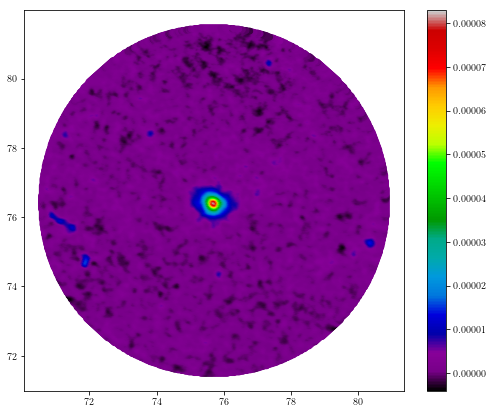

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


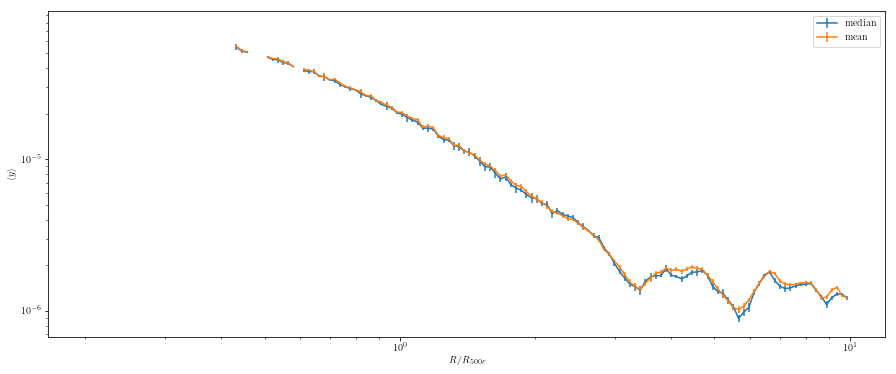

R500c in arcmin 15.433851701649036


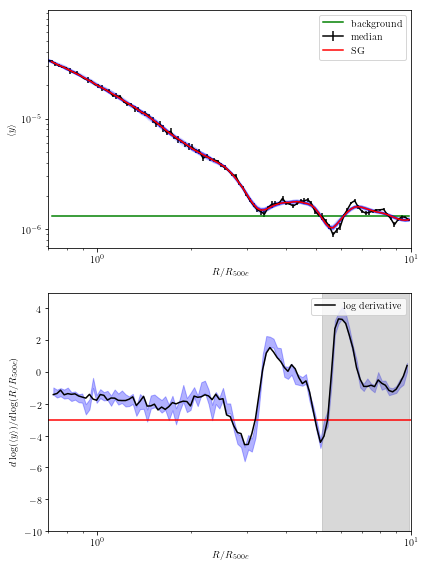

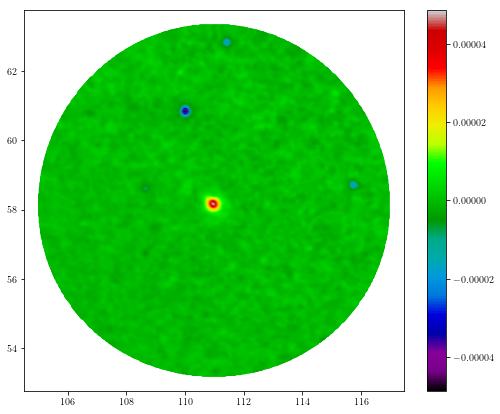

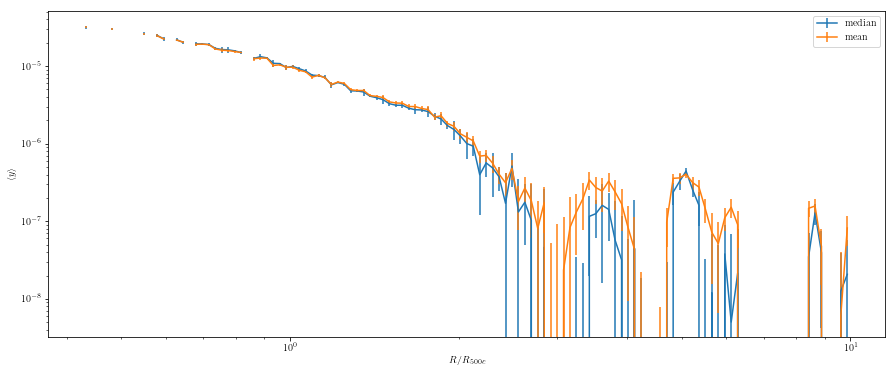

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


R500c in arcmin 15.575543069131667


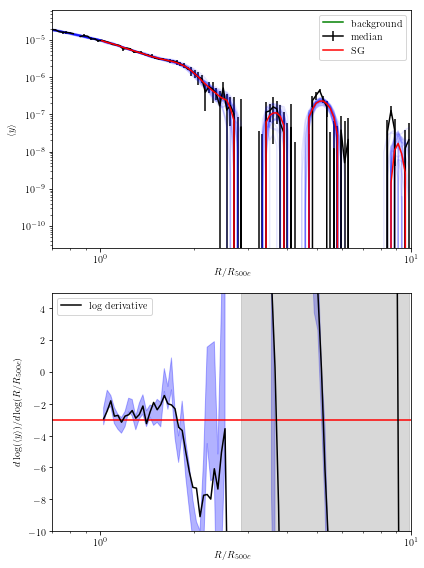

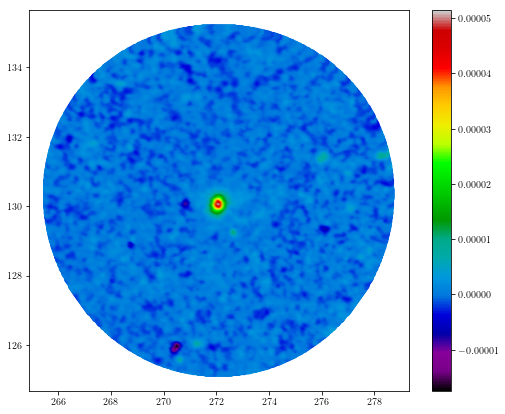

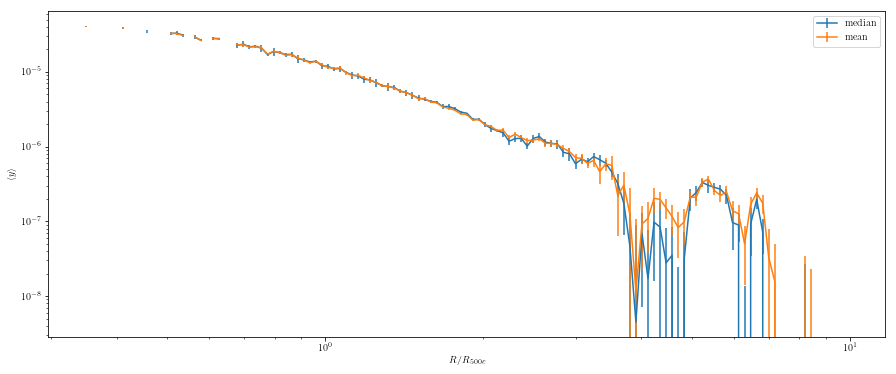

R500c in arcmin 17.039514393749737


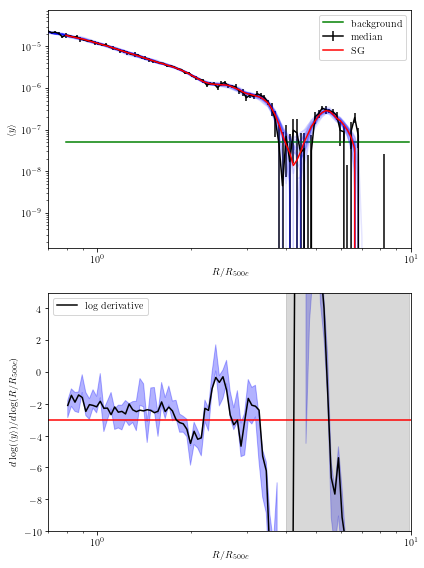

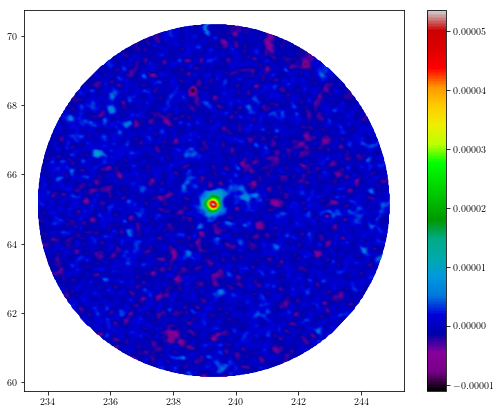

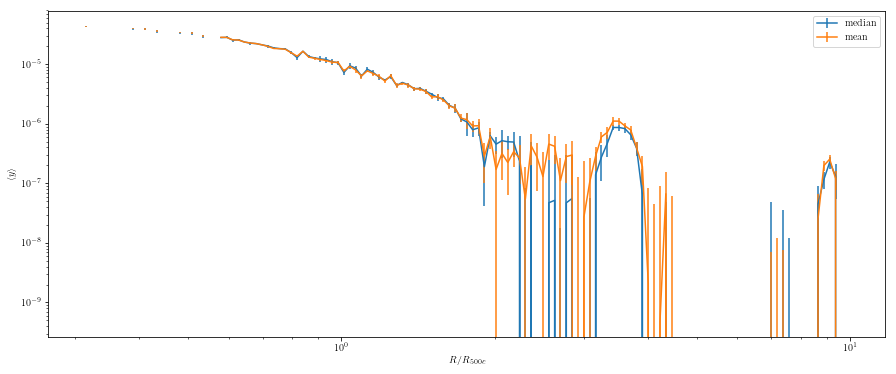

R500c in arcmin 39.47987250369788


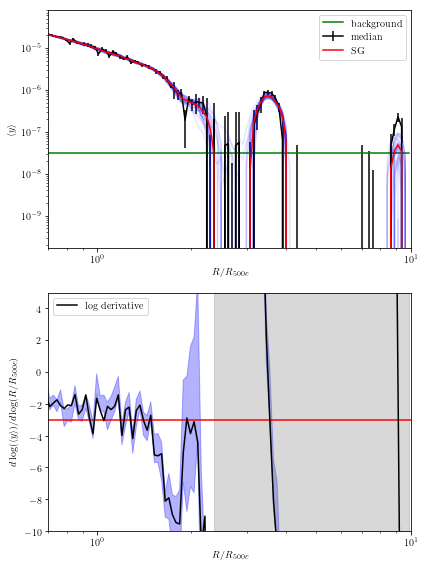

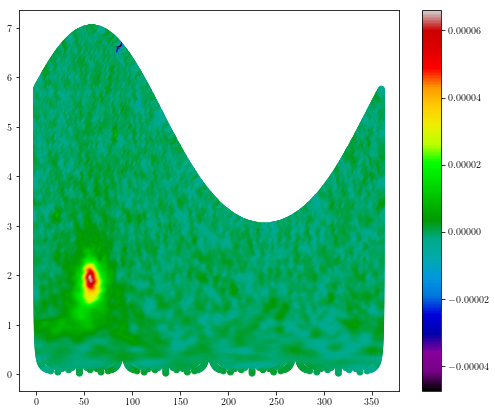

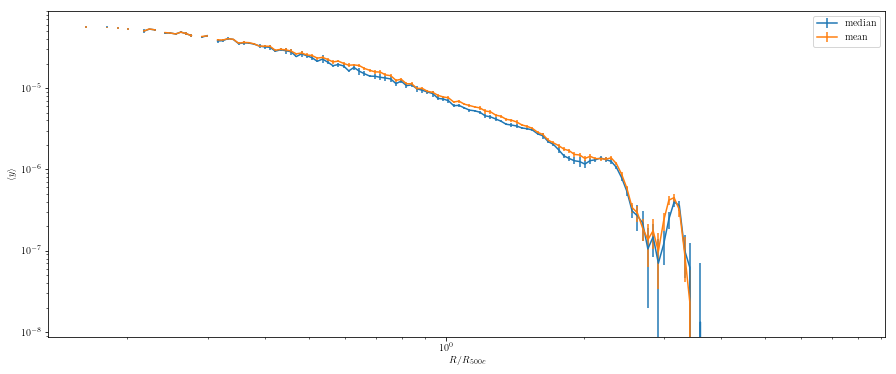

R500c in arcmin 19.03690841038709


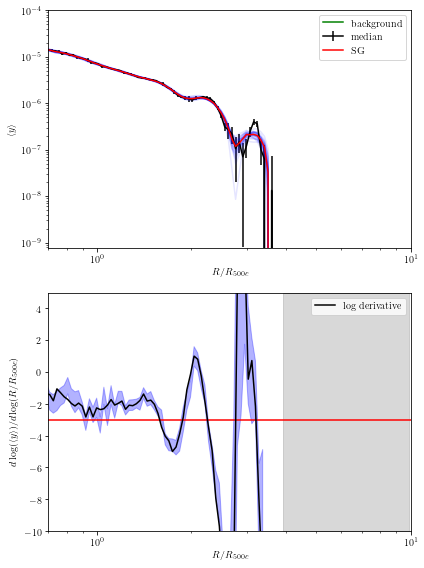

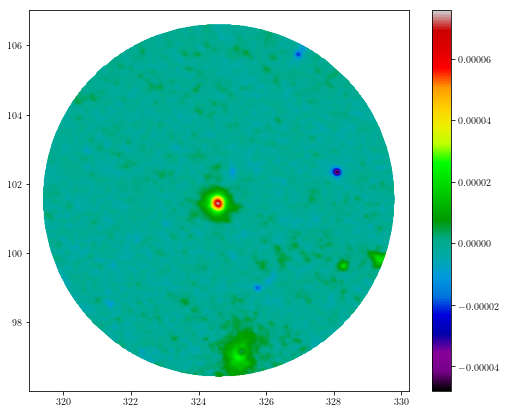

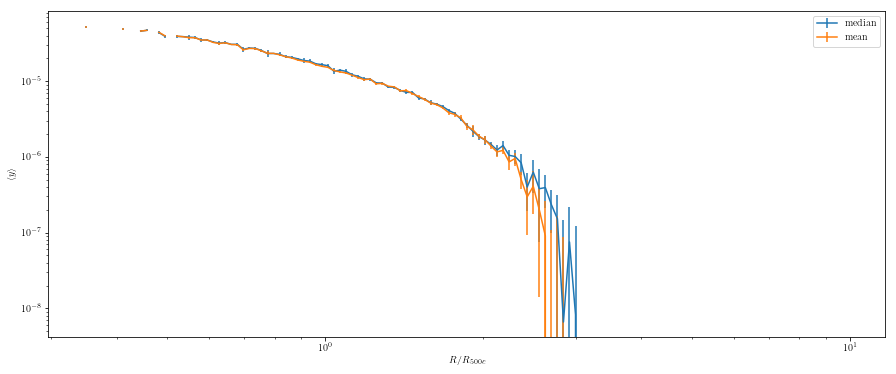

R500c in arcmin 11.554627737938292


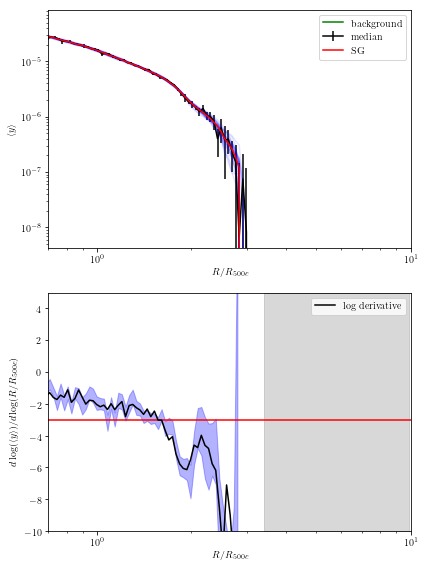

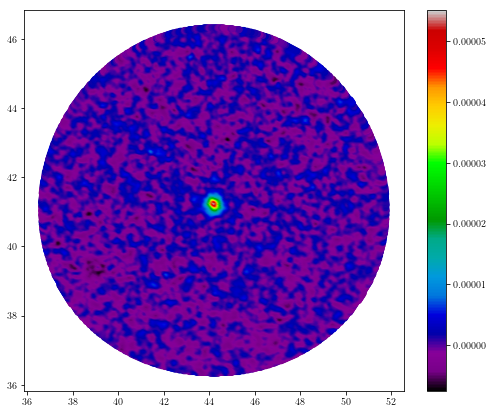

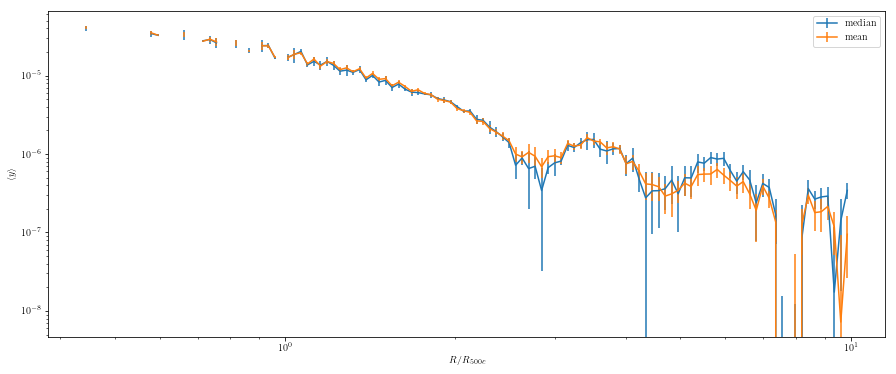

R500c in arcmin 16.776385088677685


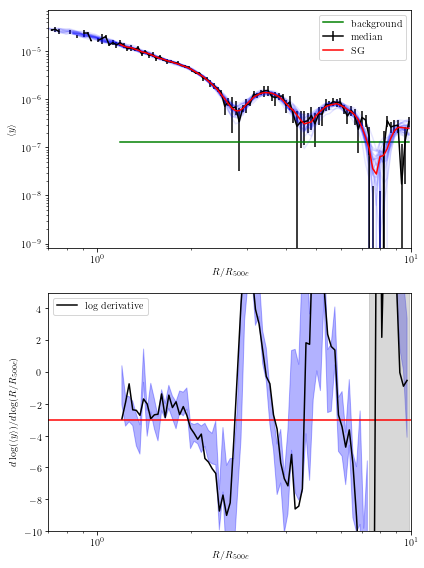

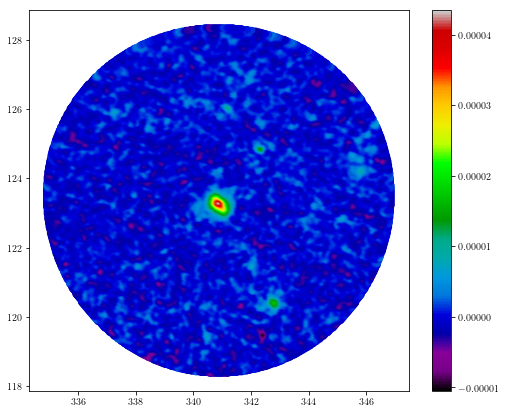

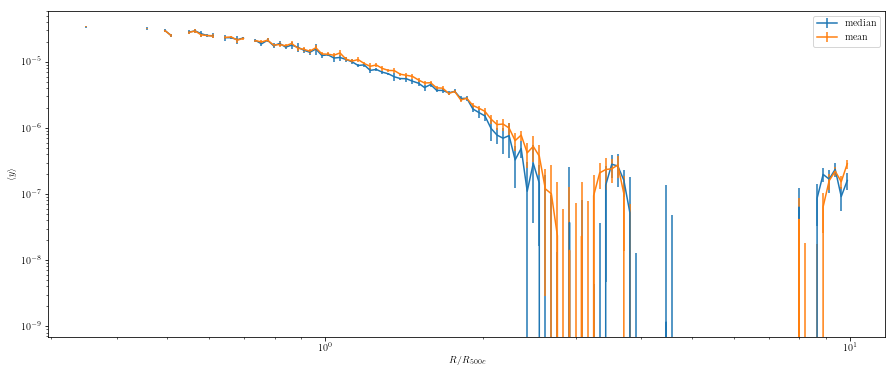

R500c in arcmin 10.774282603086933


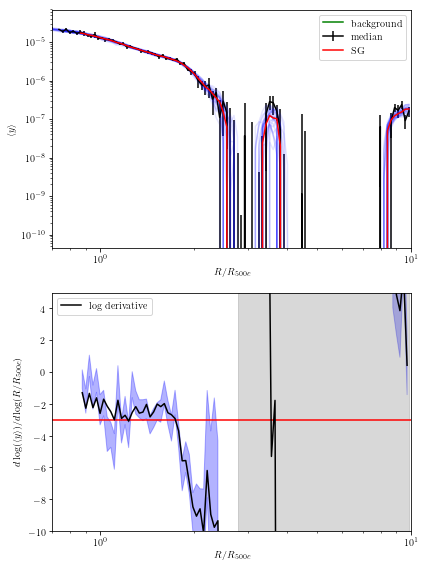

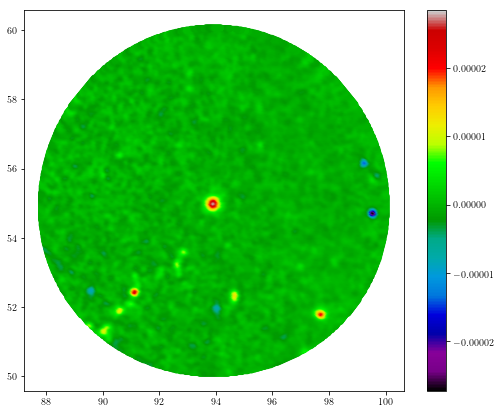

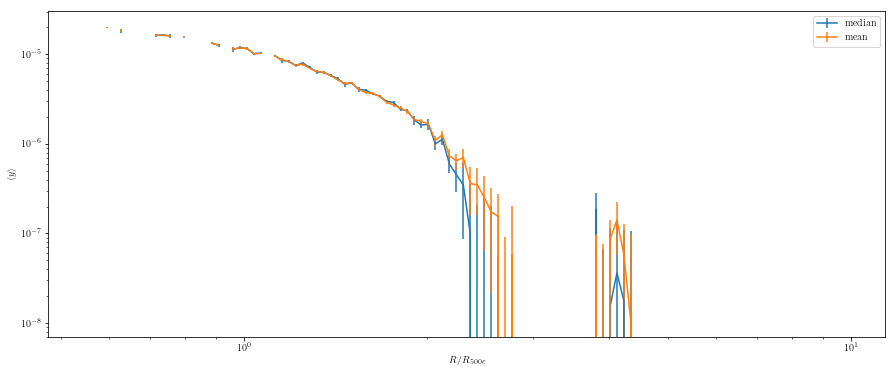

R500c in arcmin 12.398979574143912


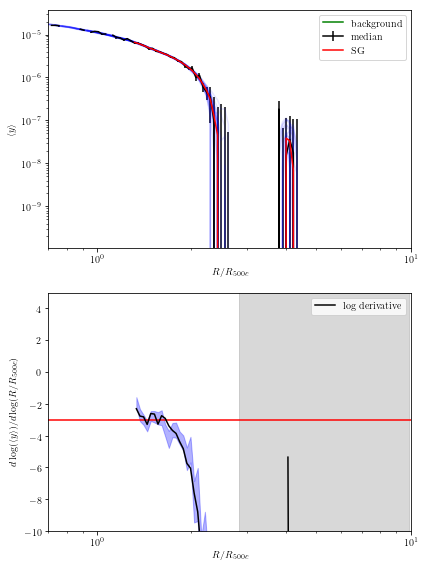

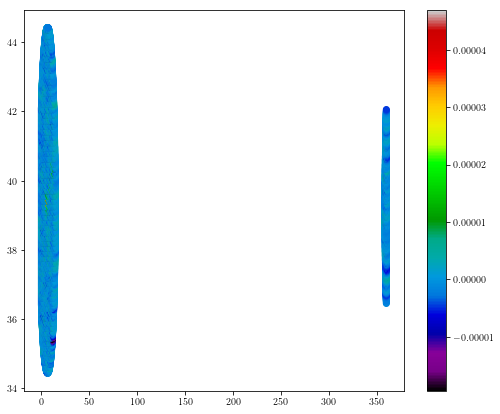

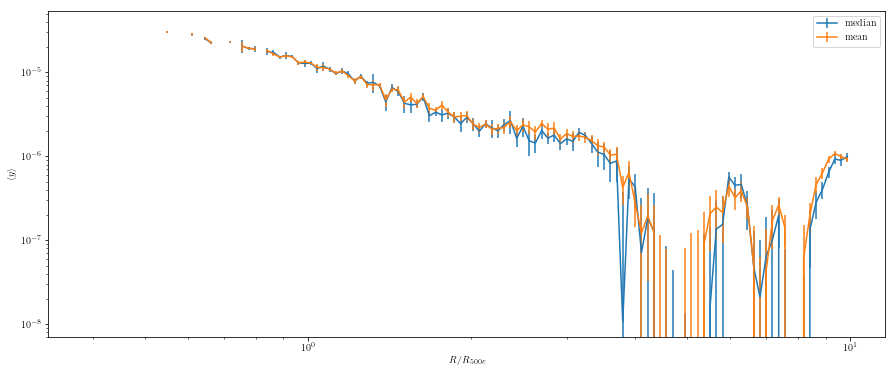

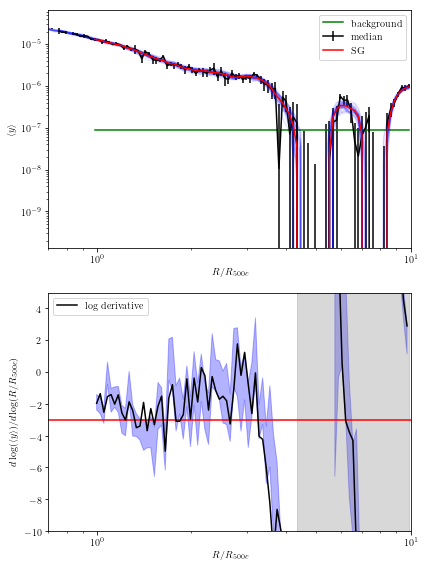

In [152]:
for i in range(10):

    R500c = (1+Z_sel[i])*M500c_to_R500c(MASS_sel[i]*10**14/Factor**3, Z_sel[i], cosmo)/cosmo.comoving_distance(Z_sel[i]).value /np.pi*180.*60
    print('R500c in arcmin', R500c)
    
    c1 = SkyCoord(LON_sel[i]*u.degree, LAT_sel[i]*u.degree, frame='icrs')
    c2 = SkyCoord(lon_y*u.degree, lat_y*u.degree, frame='icrs')
    sep = c1.separation(c2)
    mask_cluster = (sep.degree<5)

    mplot.figure(figsize=(8.5,7))
    mplot.scatter(lon_y[mask_cluster], (90. - lat_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral')
    mplot.colorbar()
    mplot.show()


    ids = np.arange(len(sz_map[mask_cluster]))
    Npix = len(sz_map[mask_cluster])
    bg_mask = (sep.value[mask_cluster]>3)

    bin_edge = np.logspace(np.log10(0.05), np.log10(10.0), num=201)
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    
    Y1_boot = []
    Y1_boot_err = []
    Y2_boot = []
    Y2_boot_err = []

    for j in range(30):
        ids_new = np.random.choice(ids, size=Npix, replace=True)

        c2_new = SkyCoord(lon_y[mask_cluster][ids_new]*u.degree, lat_y[mask_cluster][ids_new]*u.degree, frame='icrs')
        sep_new = c1.separation(c2_new)

        bg_mask_new = bg_mask[ids_new]
        bg = np.median(sz_map[mask_cluster][bg_mask_new])

        Y1 = []
        Y2 = []
        for k in range(200):
            R_over_R500 = np.array(sep_new.degree)*60.0/R500c
            mask = (R_over_R500 >= bin_min[k])*(R_over_R500 < bin_max[k])
            Y1.append(np.median(sz_map[mask_cluster][ids_new][mask]))
#             Y1.append(np.percentile(sz_map[mask_cluster][ids_new][mask], 40))
#             Y1.append(np.mean(stats.sigmaclip(sz_map[mask_cluster][ids_new][mask], low=5.0, high=5.0)[0]))
            Y2.append(np.mean(sz_map[mask_cluster][ids_new][mask]))

        Y1 = np.array(Y1)
        Y1_boot.append(Y1)
        Y2 = np.array(Y2)
        Y2_boot.append(Y2)

    Y1_boot = np.array(Y1_boot)
    Y2_boot = np.array(Y2_boot)

    Y1_err = np.std(Y1_boot, axis=0)
    Y1_mean = np.mean(Y1_boot, axis=0)
    Y2_err = np.std(Y2_boot, axis=0)
    Y2_mean = np.mean(Y2_boot, axis=0)

    DD = (bin_min+bin_max)/2

    
    mplot.figure(figsize=(15,6))
    mplot.errorbar(DD, Y1_mean, yerr=Y1_err, label='median')
    mplot.errorbar(DD, Y2_mean, yerr=Y2_err, label='mean')
    mplot.xlabel('$R/R_{500c}$')
    mplot.ylabel('$\langle y \\rangle$')
    mplot.yscale('log')
    mplot.xscale('log')
    mplot.legend()
    mplot.show()
    
    # SG smoothing including error bars
    SG = signal.savgol_filter(Y1_mean, 13, 2, mode='nearest')

    SG_boot = []
    for j in range(30):
        SG_boot.append(signal.savgol_filter(Y1_boot[j], 13, 2, mode='nearest'))

    mplot.figure(figsize=(6,8))
    mplot.subplot(211)
    for j in range(30):
        mplot.errorbar(DD, SG_boot[j], c='b', alpha=0.1)

    mplot.errorbar(DD, Y1_mean, yerr=Y1_err, color='k', label='median')
    mplot.errorbar(DD, SG, label='SG', color='r')
    mplot.plot(DD, SG*0 + bg, label='background', color='g')
    mplot.xlabel('$R/R_{500c}$')
    mplot.ylabel('$\langle y \\rangle$')

    Rcross = DD[find_cross(SG, bg)]
    
    mplot.yscale('log')
    mplot.xscale('log')
    mplot.xlim(0.7,10)
    mplot.legend()

    midR, logder = derivative(DD, SG)
    mplot.subplot(212)
    mplot.errorbar(midR, logder, label='log derivative', color='k')

    SG_err = []
    for j in range(30):
        midR, logder = derivative(DD, SG_boot[j])
        SG_err.append(derivative(DD, SG_boot[j])[1])
    SG_err = np.array(SG_err)
    mplot.fill_between(midR, logder-np.std(SG_err, axis=0), logder+np.std(SG_err, axis=0), alpha=0.3, color='b')
    mplot.fill_between(DD[DD>Rcross], DD[DD>Rcross]*0.0-10, DD[DD>Rcross]*0.0+5, color='grey', alpha=0.3)
    mplot.plot([0.7,10],[-3,-3], color='r')
    mplot.xscale('log')
    mplot.xlabel('$R/R_{500c}$')
    mplot.ylabel('$d \log(\langle y \\rangle)/d \log (R/R_{500c})$')

    mplot.xlim(0.7,10)
    mplot.ylim(-10,5)
    mplot.legend()
    mplot.tight_layout()
    mplot.savefig('SG_'+str(i)+'.pdf')
    
#     cov_boot = np.cov(Y_boot.T)

#     np.savez('Planck_cluster_bootstrap_scaled_'+str(i)+'.npz', ra=RA_sel[i], dec=DEC_sel[i], lon=LON_sel[i], 
#              lat=LAT_sel[i], z=Z_sel[i], mass=MASS_sel[i], snr=SNR_sel[i], R_over_R500=(bin_min+bin_max)/2, 
#              mean_y=Y_mean, bg=bg, cov=cov_boot)
    
    
 

## Comments:

Now we need to make sure the substructures are not making spurious shocks... or does that matter at all? I mean they could be shocks too, no?


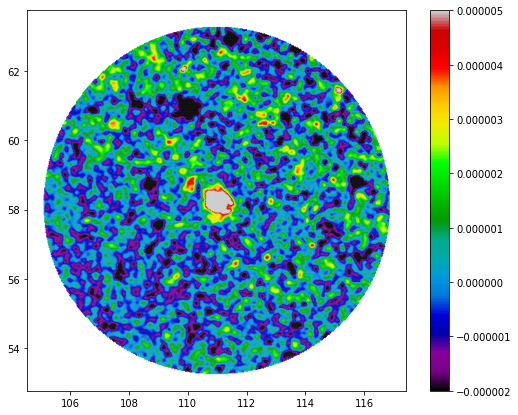

In [65]:
mplot.figure(figsize=(8.5,7))
mplot.scatter(lon_y[mask_cluster], (90. - lat_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral', s=1, marker='.')
mplot.colorbar()
mplot.clim(-0.000002,0.000005)
mplot.show()